# 신용카드 사기 탐지 모델

* trans_date_trans_time : 거래 시간
* cc_num : 카드 번호. 고유값이기 때문에 여기서는 id처럼 활용할 수 있습니다.
* merchant : 거래 상점
* category : 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
* amt : 거래 금액
* first / last : 이름
* gender : 성별
* street / state / zip : 고객 거주지 정보
* lat / long : 고객 주소에 대한 위도 및 경도
* city_pop : 고객이 zipcode에 속하는 인구 수
* job : 직업
* dob : 생년월일
* trans_num : 거래번호
* unix_time : 거래 시간(유닉스 타임스탬프 형식)
* merch_lat / merch_long : 상점 위치에 대한 위도 및 경도
* is_fraud : 사기거래 여부 (종속변수)

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import koreanize_matplotlib
import seaborn as sbn

In [75]:
def haversine(lat1, lon1, lat2, lon2):
    # 위도, 경도를 라디안 단위로 변환
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    km = 6371 * c  # 지구 반지름 = 6371km
    return km

In [87]:
data = pd.read_csv("./data/fraud.csv")
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [140]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

In [89]:
data2 =data.copy()

In [90]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [91]:
data.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06,1.852394e+06
mean,4.173860e+17,7.006357e+01,4.881326e+04,3.853931e+01,-9.022783e+01,8.864367e+04,1.358674e+09,3.853898e+01,-9.022794e+01,5.210015e-03
std,1.309115e+18,1.592540e+02,2.688185e+04,5.071470e+00,1.374789e+01,3.014876e+05,1.819508e+07,5.105604e+00,1.375969e+01,7.199217e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902742e+01,-1.666716e+02,0.000000e+00
25%,1.800429e+14,9.640000e+00,2.623700e+04,3.466890e+01,-9.679800e+01,7.410000e+02,1.343017e+09,3.474012e+01,-9.689944e+01,0.000000e+00
50%,3.521417e+15,4.745000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.443000e+03,1.357089e+09,3.936890e+01,-8.744069e+01,0.000000e+00
75%,4.642255e+15,8.310000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.374581e+09,4.195626e+01,-8.024511e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.992100e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.388534e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [21]:
from ydata_profiling import ProfileReport

In [92]:
profile = ProfileReport(data, title="카드데이터 분석")

In [13]:
profile.to_file("fraud_EDA.html")

Summarize dataset:   0%|    | 0/27 [00:00<?, ?it/s, Describe variable: category]
Summarize dataset:  41%|▍| 11/27 [00:37<00:34,  2.13s/it, Describe variable: cit
Summarize dataset:  44%|▍| 12/27 [00:37<00:31,  2.13s/it, Describe variable: job
  9%|████                                        | 2/22 [00:34<04:41, 14.08s/it]
Summarize dataset:  48%|▍| 13/27 [00:38<00:21,  1.55s/it, Describe variable: dob
Summarize dataset:  59%|▌| 16/27 [00:46<00:23,  2.15s/it, Describe variable: mer
Summarize dataset:  63%|▋| 17/27 [00:50<00:24,  2.49s/it, Describe variable: mer
Summarize dataset:  81%|▊| 22/27 [01:16<00:18,  3.76s/it, Describe variable: is_
Export report to file: 100%|██████████████████████| 1/1 [00:00<00:00, 40.78it/s]


In [10]:
data['category'].value_counts()

category
gas_transport     188029
grocery_pos       176191
home              175460
shopping_pos      166463
kids_pets         161727
shopping_net      139322
entertainment     134118
food_dining       130729
personal_care     130085
health_fitness    122553
misc_pos          114229
misc_net           90654
grocery_net        64878
travel             57956
Name: count, dtype: int64

In [156]:
data['cc_num'].nunipue()

KeyError: 'cc_num'

* 상관관계 높은 것 삭제
* 필요없는 것 삭제
* 결제지점과 고객주소간 거리 데이터 추가
* 한번 돌려서 Feature_importance 찾기
* 해당 컬럼만 추출해서 여러 모델에 돌려보기

In [158]:
data2['cc_num'].nunique()

999

In [162]:
data2[['cc_num','is_fraud']].groupby('cc_num').describe()

is_fraud                                          
                       count  mean   std   min   25%   50%   75%   max
cc_num                                                                
60416207185         2196.000 0.004 0.064 0.000 0.000 0.000 0.000 1.000
60422928733         2200.000 0.005 0.074 0.000 0.000 0.000 0.000 1.000
60423098130          738.000 0.014 0.116 0.000 0.000 0.000 0.000 1.000
60427851591          743.000 0.019 0.136 0.000 0.000 0.000 0.000 1.000
60487002085          735.000 0.011 0.104 0.000 0.000 0.000 0.000 1.000
...                      ...   ...   ...   ...   ...   ...   ...   ...
4958589671582726883 2191.000 0.003 0.056 0.000 0.000 0.000 0.000 1.000
4973530368125489546 1467.000 0.007 0.082 0.000 0.000 0.000 0.000 1.000
4980323467523543940  736.000 0.014 0.116 0.000 0.000 0.000 0.000 1.000
4989847570577635369 1471.000 0.010 0.100 0.000 0.000 0.000 0.000 1.000
4992346398065154184 2922.000 0.003 0.052 0.000 0.000 0.000 0.000 1.000

[999 rows x 8 columns]

In [97]:
data['distance'] = haversine(data['lat'], data['long'], data['merch_lat'], data['merch_long'])

In [98]:
data

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,78.597568
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,30.212176
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,108.206083
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,95.673231
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,77.556744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,77.026148
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,100.074420
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,80.759302
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,52.933240


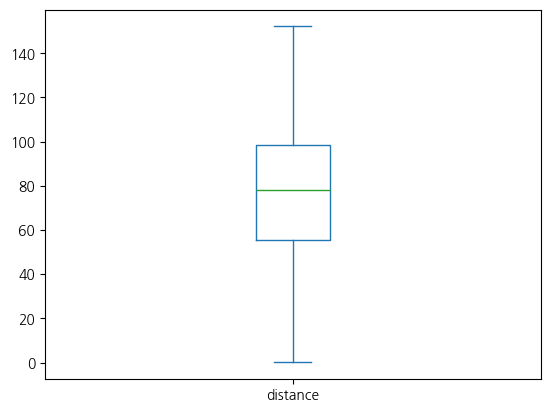

In [24]:
data['distance'].plot(kind='box')
plt.show()

In [99]:
data = data.drop(['trans_num','first','last','gender','job', 'dob','street','city','zip','job','merchant','state'], axis=1)

In [100]:
data.set_index('cc_num', inplace=True)

In [66]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'lat', 'long', 'city_pop',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'distance'],
      dtype='object')

In [108]:
data = data.drop(['trans_date_trans_time'], axis=1)

In [101]:
data

,trans_date_trans_time,category,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,distance
cc_num,,,,,,,,,,,
2703186189652095,2019-01-01 00:00:18,misc_net,4.97,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,78.597568
630423337322,2019-01-01 00:00:44,grocery_pos,107.23,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,30.212176
38859492057661,2019-01-01 00:00:51,entertainment,220.11,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,108.206083
3534093764340240,2019-01-01 00:01:16,gas_transport,45.00,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,95.673231
375534208663984,2019-01-01 00:03:06,misc_pos,41.96,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,77.556744
...,...,...,...,...,...,...,...,...,...,...,...
30560609640617,2020-12-31 23:59:07,health_fitness,43.77,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0,77.026148
3556613125071656,2020-12-31 23:59:09,kids_pets,111.84,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0,100.074420
6011724471098086,2020-12-31 23:59:15,kids_pets,86.88,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0,80.759302


In [82]:
data['cc_num'].vlaue_counts()

AttributeError: 'Series' object has no attribute 'vlaue_counts'

In [102]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

In [103]:
data['weekday'] = data['trans_date_trans_time'].dt.dayofweek  # (월=0, 일=6)

In [104]:
data['weekday_name'] = data['trans_date_trans_time'].dt.day_name()  # 'Monday', 'Tuesday' 이런 식

In [106]:
data['month'] = data['trans_date_trans_time'].dt.month


In [109]:
data

,category,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,distance,weekday,weekday_name,month
cc_num,,,,,,,,,,,,,
2703186189652095,misc_net,4.97,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,0,78.597568,1,Tuesday,1
630423337322,grocery_pos,107.23,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,30.212176,1,Tuesday,1
38859492057661,entertainment,220.11,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,0,108.206083,1,Tuesday,1
3534093764340240,gas_transport,45.00,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,0,95.673231,1,Tuesday,1
375534208663984,misc_pos,41.96,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,0,77.556744,1,Tuesday,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30560609640617,health_fitness,43.77,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0,77.026148,3,Thursday,12
3556613125071656,kids_pets,111.84,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0,100.074420,3,Thursday,12
6011724471098086,kids_pets,86.88,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0,80.759302,3,Thursday,12


In [ ]:
data['trans_date_trans_time'] = pd.cut(data['trans_date_trans_time'], 
       bins=[0,10,20,30,40,50,60,70,80,90],
      labels = ['under10s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s'])

In [96]:
data['month'] = data['trans_date_trans_time'].dt.month

AttributeError: Can only use .dt accessor with datetimelike values

In [111]:
data = pd.get_dummies(data, columns=['category', 'weekday', 'weekday_name','month'] ,drop_first=True)

In [112]:
data = pd.get_dummies(data, columns=[ 'weekday', 'weekday_name','month'] ,drop_first=True)

In [113]:
data.columns

Index(['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'distance', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weekday_name_Monday', 'weekday_name_Saturday', 'weekday_name_Sunday',
       'weekday_name_Thursday', 'weekday_name_Tuesday',
       'weekday_name_Wednesday', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [114]:
X = data.drop(['is_fraud'], axis=1)
y = data['is_fraud']

In [115]:
X

,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,distance,category_food_dining,category_gas_transport,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
cc_num,,,,,,,,,,,,,,,,,,,,,
2703186189652095,4.97,36.0788,-81.1781,3495,1325376018,36.011293,-82.048315,78.597568,False,False,...,False,False,False,False,False,False,False,False,False,False
630423337322,107.23,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,30.212176,False,False,...,False,False,False,False,False,False,False,False,False,False
38859492057661,220.11,42.1808,-112.2620,4154,1325376051,43.150704,-112.154481,108.206083,False,False,...,False,False,False,False,False,False,False,False,False,False
3534093764340240,45.00,46.2306,-112.1138,1939,1325376076,47.034331,-112.561071,95.673231,False,True,...,False,False,False,False,False,False,False,False,False,False
375534208663984,41.96,38.4207,-79.4629,99,1325376186,38.674999,-78.632459,77.556744,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30560609640617,43.77,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,77.026148,False,False,...,False,False,False,False,False,False,False,False,False,True
3556613125071656,111.84,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,100.074420,False,False,...,False,False,False,False,False,False,False,False,False,True
6011724471098086,86.88,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,80.759302,False,False,...,False,False,False,False,False,False,False,False,False,True


In [116]:
y

cc_num
2703186189652095    0
630423337322        0
38859492057661      0
3534093764340240    0
375534208663984     0
                   ..
30560609640617      0
3556613125071656    0
6011724471098086    0
4079773899158       0
4170689372027579    0
Name: is_fraud, Length: 1852394, dtype: int64

In [138]:
y.mean()

np.float64(0.005210014716091717)

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report

In [142]:
from xgboost import XGBClassifier

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, stratify=y,random_state=10)

In [148]:
categorical_features= list(range(9,X_train.shape[1]))
categorical_features

[9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

In [145]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

In [149]:
smt = SMOTENC( categorical_features=categorical_features, k_neighbors=5, random_state=10)
smt_X, smt_y =smt.fit_resample(X_train, y_train)

In [136]:
dtc = DecisionTreeClassifier(class_weight="balanced",random_state=10)
dtc.fit(X_train,y_train)
pred = dtc.predict(X_test)
print(accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

0.9962103115156324
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    737098
           1       0.65      0.60      0.62      3860

    accuracy                           1.00    740958
   macro avg       0.82      0.80      0.81    740958
weighted avg       1.00      1.00      1.00    740958



In [153]:
dtc = DecisionTreeClassifier(random_state=10)
dtc.fit(smt_X,smt_y)
pred = dtc.predict(X_test)
print(accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

0.9819261010745548
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    737098
           1       0.17      0.66      0.28      3860

    accuracy                           0.98    740958
   macro avg       0.59      0.82      0.63    740958
weighted avg       0.99      0.98      0.99    740958



In [133]:
importance = pd.DataFrame(dtc.feature_importances_)
name = pd.DataFrame(dtc.feature_names_in_)
fi = pd.concat([importance,name], axis=1)

In [134]:
fi.columns = ['importance','name']

In [152]:
fi.sort_values(by='importance', ascending=False)

,importance,name
0,0.306,amt
11,0.207,category_grocery_pos
9,0.066,category_gas_transport
4,0.054,unix_time
7,0.047,distance
3,0.046,city_pop
5,0.038,merch_lat
6,0.036,merch_long
1,0.036,lat
2,0.032,long


In [ ]:
dtc = DecisionTreeClassifier(class_weight="balanced",random_state=10)
dtc.fit(X_train,y_train)
pred = dtc.predict(X_test)
print(accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

feature importance`

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model = DecisionTreeClassifier(random_state=10)

In [ ]:
from xgboost import DecisionTreeClassifier

# geopy를 이용해 위도 경도 정보로 집과 가게의 거리 계산하기

In [163]:
from geopy.distance import distance

In [165]:
data2.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

In [173]:
data2['home_merch_dist'] = data2.apply(lambda x: distance((x['lat'], x['long']),(x['merch_lat'], x['merch_long'])).km, axis=1)

In [168]:
print(distance((data2['lat'][0], data2['long'][0]),(data2['merch_lat'][0], data2['merch_long'][0])))

78.77382075373654 km


In [174]:
data2

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,home_merch_dist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.079,-81.178,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011,-82.048,0,78.774
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.888,-118.210,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159,-118.186,0,30.217
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.181,-112.262,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.151,-112.154,0,108.103
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.231,-112.114,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034,-112.561,0,95.685
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.421,-79.463,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.675,-78.632,0,77.702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.770,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.493,-91.891,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.947,-91.333,0,77.032
1852390,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.840,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.039,-95.440,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661,-96.187,0,100.024
1852391,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.880,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.197,-118.902,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658,-119.715,0,80.888
1852392,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.990,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.626,-116.449,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.471,-117.081,0,53.061


In [178]:
dist_data = data2.groupby(['cc_num'])['home_merch_dist'].agg(['mean','std']).reset_index()

In [181]:
dist_data.columns = ['cc_num', 'dist_mean', 'dist_std']
dist_data

,cc_num,dist_mean,dist_std
0,60416207185,73.535,28.698
1,60422928733,78.986,29.299
2,60423098130,77.827,28.188
3,60427851591,75.712,28.977
4,60487002085,79.443,28.767
...,...,...,...
994,4958589671582726883,76.736,29.124
995,4973530368125489546,78.754,29.451
996,4980323467523543940,72.272,28.280
997,4989847570577635369,76.970,29.387


In [182]:
pd.merge(data, dist_data, how='left', on='cc_num')

,cc_num,amt,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,distance,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_name_Monday,weekday_name_Saturday,weekday_name_Sunday,weekday_name_Thursday,weekday_name_Tuesday,weekday_name_Wednesday,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,dist_mean,dist_std
0,2703186189652095,4.970,36.079,-81.178,3495,1325376018,36.011,-82.048,0,78.598,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,77.842,30.072
1,630423337322,107.230,48.888,-118.210,149,1325376044,49.159,-118.186,0,30.212,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,71.657,28.091
2,38859492057661,220.110,42.181,-112.262,4154,1325376051,43.151,-112.154,0,108.206,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,74.581,28.884
3,3534093764340240,45.000,46.231,-112.114,1939,1325376076,47.034,-112.561,0,95.673,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,72.049,28.892
4,375534208663984,41.960,38.421,-79.463,99,1325376186,38.675,-78.632,0,77.557,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,75.836,29.153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852389,30560609640617,43.770,40.493,-91.891,519,1388534347,39.947,-91.333,0,77.026,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,75.524,28.959
1852390,3556613125071656,111.840,29.039,-95.440,28739,1388534349,29.661,-96.187,0,100.074,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,79.173,30.051
1852391,6011724471098086,86.880,46.197,-118.902,3684,1388534355,46.658,-119.715,0,80.759,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,72.656,28.552
1852392,4079773899158,7.990,44.626,-116.449,129,1388534364,44.471,-117.081,0,52.933,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,73.689,28.255
